<a href="https://colab.research.google.com/github/ego-alt/segmentation-from-scratch/blob/master/instance_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -o -j -q -d ./full_images /content/drive/MyDrive/MP6843_img_full.zip
!unzip -o -j -q -d ./labels /content/drive/MyDrive/MP6843_inst.zip

In [4]:
import numpy as np
from os import listdir
from os.path import join
import cv2
import re

In [116]:
class ArrayMaker:
    def __init__(self, root_path):
        self.root = root_path
        self.files = {}
        self.arrdict = {}

        self.org_files()

    def main(self, dim=None, crop=None, greyscale=False):
        for name in self.files:
            for i in self.files[name]:
                if greyscale: im = cv2.imread(join(self.root, i), 0)
                else: im = cv2.imread(join(self.root, i))

                if dim: im = cv2.resize(im, dim, interpolation=cv2.INTER_AREA)
                im = np.array(im)
                if crop:
                    y, x, *_ = im.shape
                    x0 = (x - crop) // 2
                    y0 = (y - crop) // 2
                    im = im[x0:x0 + crop, y0:y0 + crop]
                self.listdict(self.arrdict, name, im)

    def org_files(self):
        regex = "^F0[1-4]_[0-9]+"
        for file in sorted(listdir(self.root)):
            if not file.startswith('.'):
                filename = re.findall(regex, file)[0]
                self.listdict(self.files, filename, file)

    def common_elements(self, other):
        stored = {k:self.arrdict[k] for k in self.arrdict if k in other}
        self.arrdict = stored

    def filtering(self, keyword):
        filtered = []
        for name in self.files:
            filename = self.files[name]
            f = [filename.index(i) for i in filename if keyword in i]
            filtered.extend(self.arrdict[name][i] for i in f)
        return filtered

    def stacking(self):
        stacked = [np.stack(self.arrdict[name],axis=-1) for name in self.arrdict]
        return stacked

    def listdict(self, dictionary, key, value):
        if key not in dictionary:
            dictionary[key] = list()
        dictionary[key].append(value)

In [117]:
lb_root = './labels'
im_root = './full_images'
dim = (696, 520)

labels = ArrayMaker(lb_root)
images = ArrayMaker(im_root)

labels.main(crop=256, greyscale=True)
images.main(dim=dim, crop=256)
images.common_elements(labels.arrdict)

w1 = images.filtering('w1')
w2 = images.filtering('w2')
labels3d = labels.stacking()
alternating = [w1[i] if i % 2 == 0 else w2[i] for i in range(len(w1))]

In [150]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [372]:
class CellImages(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind):
        img = self.transform(self.images[ind])
        lbl = self.labels[ind]
        _, _, stack_num = lbl.shape

        masks = None
        for i in range(stack_num):
            layer = lbl[:, :, i]
            obj_ids = np.unique(layer)[1:]
            if masks is None:
                masks = layer == obj_ids[:, None, None]
            else:
                current = layer == obj_ids[:, None, None]
                masks = np.concatenate((masks, current), axis=0)
        mask_num, _, _ = masks.shape

        boxes = []
        for i in range(mask_num):
            coord = np.where(masks[i])
            x0, x1 = np.min(coord[1]), np.max(coord[1])
            y0, y1 = np.min(coord[0]), np.max(coord[0])
            boxes.append([x0, y0, x1, y1])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((mask_num,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.as_tensor([ind])
        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        iscrowd = torch.zeros((mask_num,), dtype=torch.int64)
      
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

In [373]:
train_loader = DataLoader(CellImages(w1[0:40], labels3d[0:40]), 
                          batch_size=2, shuffle=False, 
                          collate_fn=lambda x:list(zip(*x)))

test_loader = DataLoader(CellImages(w1[40:45], labels3d[40:45]), 
                          batch_size=5, shuffle=False,
                          collate_fn=lambda x:list(zip(*x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


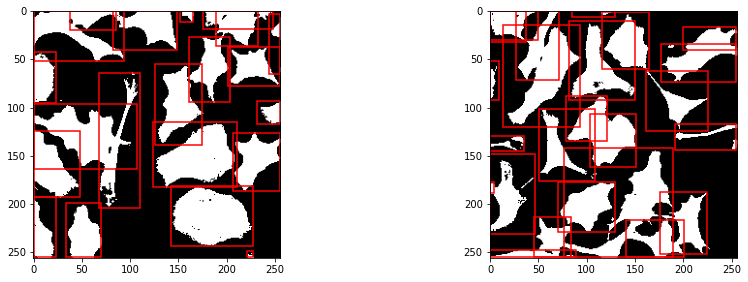

In [383]:
import matplotlib.pyplot as plt
from matplotlib import patches

images,labels = next(iter(train_loader))

def view(images, labels, n=2, std=1, mean=0):
    figure = plt.figure(figsize=(15,10))
    images = list(images)
    labels = list(labels)
    for i in range(n):
        out = torchvision.utils.make_grid(images[i])
        inp = out.cpu().numpy().transpose((1,2,0))
        inp = np.array(std)*inp+np.array(mean)
        inp = np.clip(inp,0,1)  
        ax = figure.add_subplot(2, 2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1,2,0)) * 255)
        l = labels[i]['boxes'].cpu().numpy()
        l[:,2] = l[:,2]-l[:,0]
        l[:,3] = l[:,3]-l[:,1]
        for j in range(len(l)):
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],
                                           linewidth=1.5,
                                           edgecolor='r',
                                           facecolor='none')) 

view(images=images, labels=labels, n=2, std=1, mean=0)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)
model.eval() 